# Lập trình thống kê Python: 

# Phân tích đường cong ROC

### BS. Lê Ngọc Khả Nhi


# Giới thiệu

Phân tích đường cong ROC (Receiver Operating Characteristic) là một trong những kỹ thuật phân tích đơn biến cơ bản mà sinh viên Y khoa được học trong giáo trình Thống kê. Tuy nhiên trên thực tế không phải tất cả bác sĩ đều hiểu rõ bản chất của phân tích đường cong ROC chính là một bài toán tối ưu hóa quy luật nhị phân áp dụng cho một thang đo liên tục. 

Mục tiêu của bài toán này nhằm xác định ngưỡng cắt tối ưu của một thông số xét nghiệm để đưa ra một quyết định lâm sàng mang tính nhị phân (loại trừ hay xác định bệnh lý), hay nói cách khác, định ranh giới trên thang đo để cắt thang đo này thành 2 khoảng riêng biệt, thí dụ: bệnh lý và bình thường. Ta sẽ di chuyển từng bước trên thang đo và tại mỗi điểm, ước tính 2 chỉ số: True positive rate (TPR) và True negative rate (TNR), hay Sensitivity và 1-Specificity. Đường cong ROC mà ta biết chính là hình ảnh của tất cả các kết quả TNR, TPR tương ứng với rất nhiều điểm trên thang đo.

Trong bài thực hành hôm nay, Nhi sẽ hướng dẫn các bạn dùng ngôn ngữ Python để thực hiện thủ công một phân tích ROC.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

np.random.seed(123)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *
import itertools
from imblearn.over_sampling import SMOTE

from scipy import interp

%config InlineBackend.figure_format = 'svg'

# Thí dụ minh họa

Thí dụ ta có một chỉ số xét nghiệm Marker, và mục tiêu đặt ra là xác định một ngưỡng cắt tối ưu nhất của chỉ số này cho phép chẩn đoán (Diagnosis =1) hoặc loại trừ (Diagnosis=0) một căn bệnh.

Nhi tải dữ liệu từ github của mình:

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/kinokoberuji/R-Tutorials/master/ROCdf.csv", sep = ';')

df

,Marker,Diagnosis
0,19.396250,1
1,48.747631,1
2,30.151102,1
3,22.956150,1
4,8.329277,0
...,...,...
395,8.103378,0
396,7.645763,0
397,8.275276,0
398,12.014207,0


Đầu tiên, Nhi dùng KDE plot để thăm dò trực quan phân phối của Marker trong 2 nhóm Diagnosis. Biểu đồ cho thấy có sự chồng lắp đáng kể giữa 2 phân bố, như vậy mục tiêu của ta là chọn ra một ngưỡng phù hợp để cân bằng giữa false negative và false positive, mặt khác không có ngưỡng cắt nào là tuyệt đối hoàn hảo.

Text(0.5, 0, 'Marker')

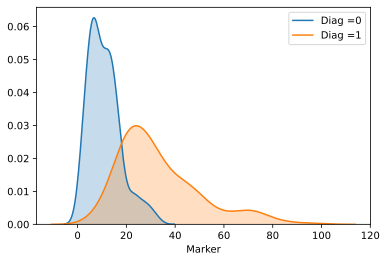

In [11]:
for i in [0,1]:
    sns.kdeplot(df[df['Diagnosis']==i]['Marker'], shade = True, label = f'Diag ={i}')
plt.xlabel('Marker')

Ta lại lưu ý rằng tỉ lệ phân bố giữa 2 nhãn là không đồng đều, có 223 trường hợp dương tính và 177 trường hợp âm tính. Trong phần tiếp theo, Nhi sẽ dùng 1 kỹ thuật oversampling là SMOTE để cân bằng tỉ lệ này, việc xử lý này không ảnh hưởng nhiều đến kết quả sau cùng nếu tối ưu ngưỡng cắt dựa vào tiêu chí Youden'J hoặc Balanced accuracy, nhưng nếu ta dùng tiêu chí F1 thì có thể sẽ khác.

In [12]:
df.Diagnosis.value_counts()

1    223
0    177
Name: Diagnosis, dtype: int64

# Xây dựng class ROC_analysis

Tiếp theo, Nhi dùng Python OOP để lập trình thủ công 1 class cho phép nhận dữ liệu đầu vào là 2 arrays Marker, Diagnosis; sau đó lần lượt dùng 2 methods là cutoff_analysis và Boot_ROCcurve để :

1) Xác định ngưỡng cắt tối ưu cho Marker để đạt hiệu năng chẩn đoán chính xác nhất, theo tiêu chí tùy chọn (F1 score, BAC, hoặc Youden'J)

2) Với ngưỡng cắt tối ưu này, vẽ đường cong ROC và tính trung bình, khoảng tin cậy của diện tích dưới đường cong ROC này bằng bootstrap

Bên trong class này, diễn ra quy trình như sau:

1) Khi khởi tạo 1 object phân tích ROC, ta nhập 2 array X và Y tương ứng với Marker, Diagnosis,

2) Dùng SMOTE oversampling để cân bằng 2 nhãn nhị phân trong Y, lưu dữ liệu X,Y sau tái chọn mẫu

3) Hàm binary_rule cho phép hoán chuyển array X thành 1 chuỗi giá trị nhị phân 0,1, nếu giá trị X cao hơn 1 ngưỡng (thres) xác định

4) Method cutoff_analysis sẽ lần lượt tính 9 metrics gồm độ nhạy, độ đặc hiệu, F1 score, BAC, PPV, NPV, LR+, LR- và Youden'J cho 1000 vị trí khác nhau trên thang đo của X; sau đó chọn ra ngưỡng cắt tối ưu để có F1, BAC hoặc Youden'J cao nhất.

5) Method Boot_ROCcurve thực hiện 1 bootstrap 1000 lượt để tính FPR, TPR và AUC của 1000 đường cong ROC khác nhau, sau đó vẽ hình.

In [13]:
class ROC_analysis:
    
    def __init__(self, X, Y):
        
        sm = SMOTE()
        X,Y = sm.fit_sample(X.values.reshape(-1, 1), Y)
        self.X, self.Y = pd.Series(X.ravel()),Y
    
    def binary_rule(self, thres = None):
        score = self.X
        lab_rule = {thres:1,0:0}
    
        def lab_mapping(value):
            for k, lab in lab_rule.items():
                if value >= k:
                    return lab

        pred = score.map(lab_mapping)

        return score, pred.values
    
    def cutoff_analysis(self, resolution = 1000, xmin = 0.1, crit = 'F1'):
        
        thres_list = np.linspace(xmin, self.X.max(), resolution)
        temp_perf = np.zeros(10)
        
        for t in thres_list:
        
            score, pred = self.binary_rule(thres = t)

            cnf_matrix = confusion_matrix(self.Y,pred)

            TN, FP, FN, TP = cnf_matrix.ravel()
            TPR=TP/(TP+FN)
            TNR=TN/(TN+FP)
            SEN=TPR
            SPEC=TNR
            Recall=SEN
            ACC=(TP+TN)/(TP+FP+TN+FN)
            PPV=TP/(TP+FP)
            NPV=TN/(TN+FN)
            LRpos=SEN/(1-SPEC)
            LRneg=(1-SEN)/SPEC
            J = SEN + SPEC - 1

            f1 = f1_score(self.Y, pred)
            bac = balanced_accuracy_score(self.Y, pred)
            
            temp_perf = np.vstack([temp_perf, [t, SEN, SPEC, f1, bac, PPV, NPV, LRpos, LRneg, J]])
        
        perf_df = pd.DataFrame(temp_perf).iloc[1:]
        perf_df.columns = ['Thres', 'Sen', 'Spec', 'F1', 'BAC', 'PPV', 'NPV', 'LRp', 'LRn', 'Youden_J']
        best_cut = perf_df[perf_df[crit] == perf_df[crit].max()]
        
        print(f'Xác định ngưỡng cắt tối ưu theo tiêu chí {crit}')
        
        self.best_cut = best_cut
        self.perf_df = perf_df
                    
        plt.rcParams.update({'font.size': 12})
        plt.figure(figsize=(10,6))
        plt.plot(thres_list[:-1], self.perf_df['Spec'][:-1], label="Độ đặc hiệu", linewidth=2)
        plt.plot(thres_list[:-1], self.perf_df['Sen'][:-1], label="Độ nhạy", linewidth=2)
        plt.plot(thres_list[:-1], self.perf_df['F1'][:-1], label="Điểm F1", linewidth=2)
        plt.plot(thres_list[:-1], self.perf_df['BAC'][:-1], label="Độ chính xác", linewidth=2)
        plt.plot(thres_list[:-1], self.perf_df['Youden_J'][:-1], label="Youden'J", linewidth=2)
        
        bc = self.best_cut['Thres'].values[0]
        plt.vlines(x = bc, 
                   ymin = 0.1, 
                   ymax = 1, 
                   colors = 'k', 
                   linestyles='dashed',
                  label = f'Ngưỡng tối ưu:{bc:.2f}')

        plt.xlabel("Thang đo", fontsize=15)
        plt.ylabel("Điểm số", fontsize=15)
        plt.legend(fontsize=12)
        plt.ylim([0.1, 1])
        plt.xlim([0.1, self.X.max()])
        
        return best_cut

    def Boot_ROCcurve(self,n_iter = 1000):
                    
        score, pred = self.binary_rule(thres = self.best_cut['Thres'].values[0])
        tprs = []
        aucs = []
        base_fpr = np.linspace(0, 1, 101)

        valid_df = pd.DataFrame({'Truth': self.Y,
                                 'Pred': pred,
                                 'Score': score},
                                index = self.Y.index)

        for i in range(n_iter):
            resamp_df = valid_df.sample(1000, replace=True)

            if len(np.unique(resamp_df['Pred'])) < 2:
                continue

            fpr, tpr, _ = roc_curve(resamp_df['Truth'], resamp_df['Score'])

            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)

            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)
        mean_auc = auc(base_fpr, mean_tprs)
        std_auc = np.std(aucs)

        tprs_up = np.minimum(mean_tprs + 1.645*std, 1)
        tprs_low = mean_tprs - 1.645*std

        plt.rcParams["figure.figsize"] = (7,6.6)
        plt.rcParams.update({'font.size': 15})

        plt.plot(base_fpr, mean_tprs, 'r', 
                 alpha = 1, 
                 label=r'AUC = %0.3f $\pm$ %0.3f' % (mean_auc, std_auc),)

        plt.fill_between(base_fpr, 
                         tprs_low, tprs_up, 
                         color = 'red', alpha = 0.3)

        plt.plot([0, 1], [0, 1], 
                 linestyle = '--', 
                 lw = 2, 
                 color = 'grey', 
                 label = 'Đoán ngẫu nhiên', 
                 alpha= 0.5)
        
        plt.vlines(x = 1 - self.best_cut['Spec'], 
                   ymin = 0., 
                   ymax = 1, 
                   colors = 'k', 
                   linestyles='dashed',)
        
        plt.hlines(y = self.best_cut['Sen'], 
                   xmin = 0., 
                   xmax = 1, 
                   colors = 'k', 
                   linestyles='dashed',)
        
        plt.plot(1 - self.best_cut['Spec'],
                 self.best_cut['Sen'], 
                 'ko')

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])

        plt.ylabel('Tỉ lệ dương tính thật')
        plt.xlabel('Tỉ lệ dương tính giả')
        plt.legend(loc="lower right")
        plt.title('Đường cong ROC')

# Sử dụng công cụ ROC analysis

Đầu tiên, ta khởi tạo object r:

In [14]:
r = ROC_analysis(df['Marker'], df['Diagnosis'])

Sử dụng method cutoff_analysis với độ phân giải 1000 điểm, ngưỡng xmin = 0.1, tiêu chí tối ưu hóa là F1 (bạn có thể chọn Youden's J theo cách làm cổ điển).

Xác định ngưỡng cắt tối ưu theo tiêu chí F1


,Thres,Sen,Spec,F1,BAC,PPV,NPV,LRp,LRn,Youden_J
180,17.428002,0.90583,0.874439,0.891832,0.890135,0.878261,0.902778,7.214286,0.107692,0.780269


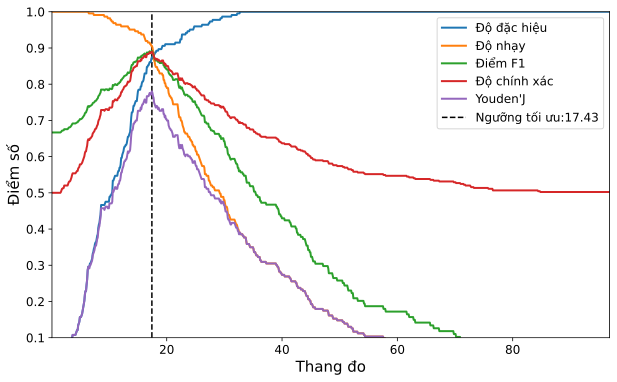

In [15]:
r.cutoff_analysis(resolution = 1000, xmin = 0.1, crit = 'F1')

Cuối cùng, dùng method Boot_ROCcurve() để vẽ hình.

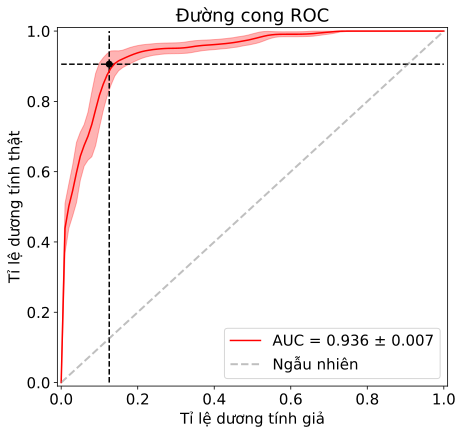

In [156]:
r.Boot_ROCcurve()

Bạn có thể trích xuất toàn bộ dataframe của 1000 ngưỡng cắt từ object r:

In [16]:
r.perf_df

,Thres,Sen,Spec,F1,BAC,PPV,NPV,LRp,LRn,Youden_J
1,0.100000,1.000000,0.0,0.666667,0.500000,0.5,NaN,1.0,NaN,0.000000
2,0.196804,1.000000,0.0,0.666667,0.500000,0.5,NaN,1.0,NaN,0.000000
3,0.293609,1.000000,0.0,0.666667,0.500000,0.5,NaN,1.0,NaN,0.000000
4,0.390413,1.000000,0.0,0.666667,0.500000,0.5,NaN,1.0,NaN,0.000000
5,0.487218,1.000000,0.0,0.666667,0.500000,0.5,NaN,1.0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...
996,96.420458,0.004484,1.0,0.008929,0.502242,1.0,0.501124,inf,0.995516,0.004484
997,96.517262,0.004484,1.0,0.008929,0.502242,1.0,0.501124,inf,0.995516,0.004484
998,96.614067,0.004484,1.0,0.008929,0.502242,1.0,0.501124,inf,0.995516,0.004484
999,96.710871,0.004484,1.0,0.008929,0.502242,1.0,0.501124,inf,0.995516,0.004484


# Tổng kết

Bài thực hành đến đây là hết. Các bạn đã có trong tay một phân tích ROC bằng ngôn ngữ Python, hoàn toàn Việt hóa và có phẩm chất tương đương bất cứ phần mềm thống kê thương mại nào khác.